# Group Members:
Volreka Senatus, Michelle Pancier, Ruslan Sdobnikov, Tuntufye Mwakalasya

# Imports

In [4]:
!pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 603.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


# Loading Data

In [2]:
import os
import shutil
import zipfile
import requests
from tqdm import tqdm

RUNNING_ON_COLAB = True

def download_and_unzip(url, extract_to):
    filename = url.split("/")[-1]
    print(f"Downloading {filename}...")
    response = requests.get(url, stream=True)
    with open(filename, "wb") as f:
        total = int(response.headers.get("content-length", 0))
        with tqdm.wrapattr(f, "write", total=total) as out_file:
            for chunk in response.iter_content(chunk_size=8192):
                out_file.write(chunk)
    print(f"Unzipping {filename}...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(filename)

def flatten_folder(source_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(root, file)
                dst = os.path.join(target_dir, file)
                shutil.copy2(src, dst)

if RUNNING_ON_COLAB:
    os.makedirs("data/real", exist_ok=True)
    os.makedirs("data/fake", exist_ok=True)

    urls = {
        "wiki": "https://huggingface.co/datasets/OpenRL/DeepFakeFace/resolve/main/wiki.zip",
        "inpainting": "https://huggingface.co/datasets/OpenRL/DeepFakeFace/resolve/main/inpainting.zip",
    }

    for name, url in urls.items():
        extract_dir = f"temp/{name}"
        download_and_unzip(url, extract_dir)
        target = "data/real" if name == "wiki" else "data/fake"
        flatten_folder(extract_dir, target)

else:
    flatten_folder("C:/data/wiki", "data/real")
    flatten_folder("C:/data/inpainting", "data/fake")

print("Real images:", len(os.listdir("data/real")))
print("Fake images:", len(os.listdir("data/fake")))




100%|██████████| 1.65G/1.65G [00:06<00:00, 284MB/s]


Unzipping wiki.zip...


100%|██████████| 1.01G/1.01G [00:03<00:00, 290MB/s]


Unzipping inpainting.zip...
Real images: 30000
Fake images: 30000


# Dataset

In [9]:
# --------- CONFIG ---------
image_size = (224, 224)
batch_size = 200
data_dir = "data"

# --------- LOAD RAW DATASETS ---------
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

# --------- CLASS NAMES ---------
class_names = raw_train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)

# --------- NORMALIZATION & PIPELINE OPTIMIZATION ---------
normalization_layer = tf.keras.layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    raw_train_ds
    .map(lambda x, y: (normalization_layer(x), y))
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    raw_val_ds
    .map(lambda x, y: (normalization_layer(x), y))
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)



Found 60000 files belonging to 2 classes.
Using 48000 files for training.
Found 60000 files belonging to 2 classes.
Using 12000 files for validation.
Class names: ['fake', 'real']


# Model Definition

In [10]:
# -------- MODEL DEFINITION ---------

base_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

base_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --------- TRAINING ---------
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("TPU found:", resolver.cluster_spec())
except ValueError:
    print("TPU not found")


try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Running on TPU")
except ValueError:
    strategy = tf.distribute.get_strategy()  # default CPU/GPU strategy
    print("Running on CPU/GPU")

with strategy.scope():
    refined_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.20),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    refined_model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
    )



TPU not found
Running on CPU/GPU


In [ ]:
print("---------------ORIGINAL MODEL-----------------------")
# --------- TRAINING ---------
base_history = base_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=10,
    batch_size = 128
)

In [11]:
print("---------------REFINED MODEL-----------------------")
# --------- TRAINING ---------
refined_history = refined_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=10,
    batch_size = 128
)

---------------REFINED MODEL-----------------------
Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1136s 5s/step - accuracy: 0.5074 - loss: 0.6933 - val_accuracy: 0.5113 - val_loss: 0.6931
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1126s 5s/step - accuracy: 0.5284 - loss: 0.6885 - val_accuracy: 0.5532 - val_loss: 0.6846
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1128s 5s/step - accuracy: 0.6239 - loss: 0.6322 - val_accuracy: 0.7212 - val_loss: 0.5506
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1132s 5s/step - accuracy: 0.7542 - loss: 0.4924 - val_accuracy: 0.8133 - val_loss: 0.4069
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1133s 5s/step - accuracy: 0.8263 - loss: 0.3765 - val_accuracy: 0.9580 - val_loss: 0.1024
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1137s 5s/step - accuracy: 0.9805 - loss: 0.0538 - val_accuracy: 0.9923 - val_loss: 0.0312
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1140s 5s/step - accuracy: 0.9937 - loss: 0.0214 - val_accuracy: 0.9932 - val_loss: 0.0253
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━

# Evaluation

60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 449ms/step - accuracy: 0.9667 - loss: 0.1184

✅ Evaluation Results:
Test loss: 0.1175
Test accuracy: 0.9678


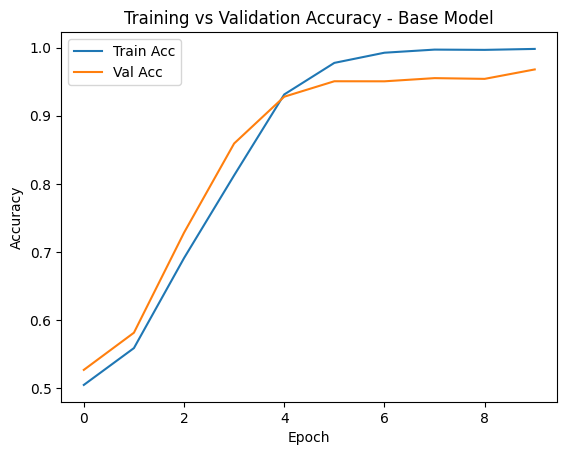

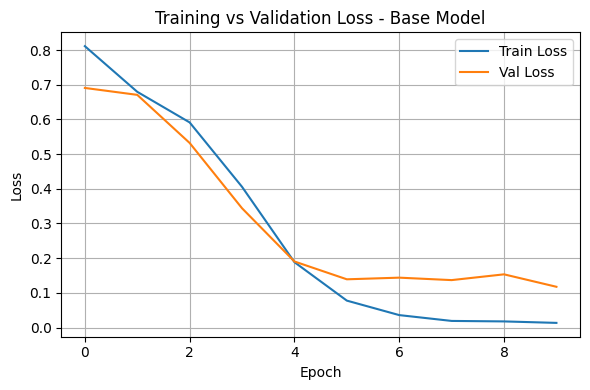

In [ ]:
# --------- EVALUATE ON VALIDATION SET - BASE ---------
loss, acc = base_model.evaluate(val_ds, verbose=1)

print(f"\n Evaluation Results: Base Model")
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")



#---Plot
#Accuracy Plot
plt.plot(base_history.history['accuracy'], label='Train Acc')
plt.plot(base_history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy - Base Model')
plt.legend()
plt.show()


# Loss Plot
plt.figure(figsize=(6, 4))
plt.plot(base_history.history['loss'], label='Train Loss')
plt.plot(base_history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss - Base Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 618ms/step - accuracy: 0.9959 - loss: 0.0162

 Evaluation Results: Refined Model
Test loss: 0.0165
Test accuracy: 0.9962


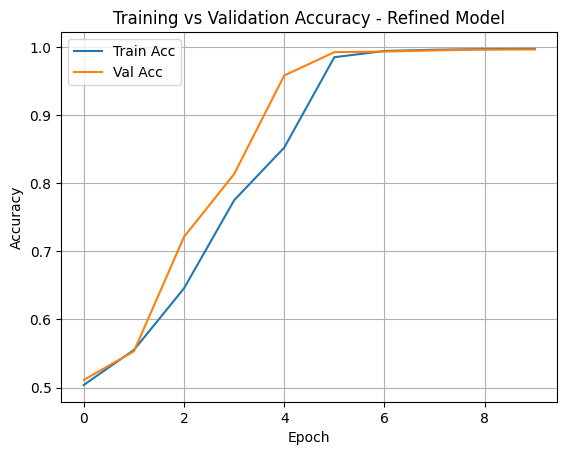

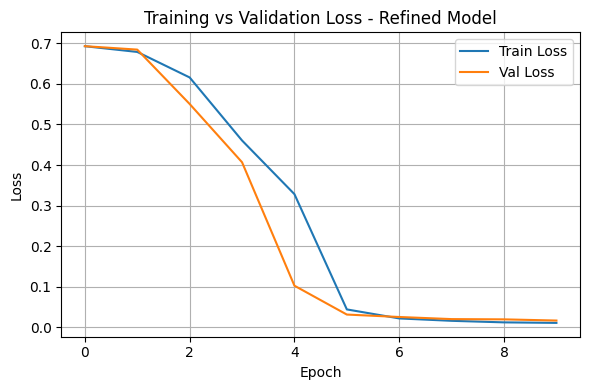

In [14]:
loss, acc = refined_model.evaluate(val_ds, verbose=1)

print(f"\n Evaluation Results: Refined Model")
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")

#Accuracy Plot
plt.plot(refined_history.history['accuracy'], label='Train Acc')
plt.plot(refined_history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy - Refined Model')
plt.grid(True)
plt.legend()
plt.show()


# Loss Plot
plt.figure(figsize=(6, 4))
plt.plot(refined_history.history['loss'], label='Train Loss')
plt.plot(refined_history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss - Refined Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix

60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 444ms/step


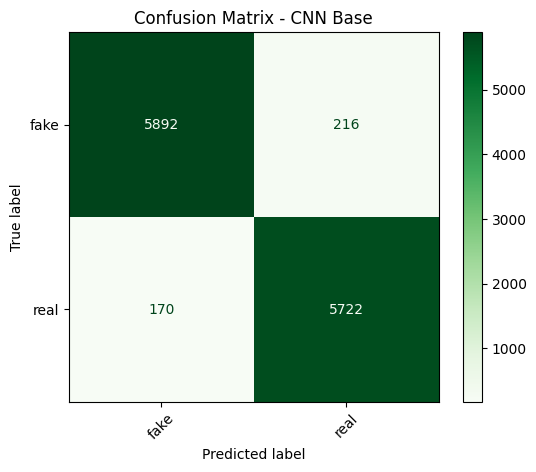

In [ ]:
# BASE MODEL
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
predictions = base_model.predict(val_ds)
y_pred = np.argmax(predictions, axis=1)

# Extract true labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

f1_score = f1_score(y_true, y_pred, average=None)
print("F1 score (Base Model): ", f1_score)


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title('Confusion Matrix - Base Model')
plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 610ms/step
F1 score (Refined Model):  [0.99623691 0.99609375]


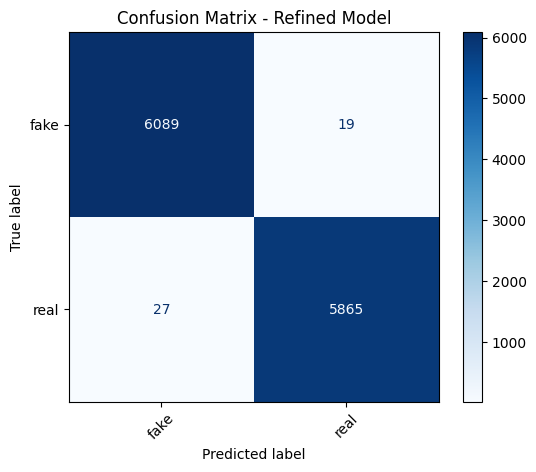

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# REFINED MODEL
predictions = refined_model.predict(val_ds)
y_pred = np.argmax(predictions, axis=1)

# Extract true labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

f1_score = f1_score(y_true, y_pred, average=None)
print("F1 score (Refined Model): ", f1_score)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Refined Model')
plt.show()